<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/ensemble/voting/02_voting_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [242]:
import warnings
from unicodedata import normalize

import random

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process  import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


from sklearn.metrics import (
    mean_absolute_error
)

from sklearn.ensemble import VotingRegressor

# **Info**
---
**@By**: **Steven Bernal**

**@Nickname**: **Kaiziferr**

**@Git**: https://github.com/Kaiziferr

The purpose of this mini project is to demonstrate the ability to assemble different models to make a prediction. Validating a better performance than what each model could individually.

# **Config**
---

In [243]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.5f}'.format)
title_data = 'Materiales extraidos en Colombia'
random_seed=12354
warnings.filterwarnings("ignore")

# **Functions**

---




In [244]:
def normalize_word(word)->str:
  """Normaliza palabras"""
  word = word.replace(' ', '_')
  find_guion = word.find('_')
  list_word = []
  if find_guion:
    list_word = [w for w in word.split('_') if w != '']
  else:
    list_word = word
  word = list(map(lambda x: x.lower(), list_word))
  word = [normalize('NFKD', c).encode('ASCII', 'ignore').decode() for c in word]
  word = "_".join(word)
  return word


def normalize_name_columns(columns):
  """Normaliza columnas"""
  columns = list(map(lambda x: normalize_word(x), columns))
  return columns


def generate_colors(paleta:str="Set1", n_colors:int=15)-> tuple:
  """color generator"""
  try:
    cmap = sns.color_palette(paleta, n_colors).as_hex()
    list_camp = ListedColormap(cmap)
    return cmap, list_camp
  except Exception as e:
    print(e)

def plot_bar(data:pd.DataFrame, paleta:list=None, figsize_x:int=8, figsize_y:int=5,
             fontsize:int=15, **kwards)->None:
  """Grafica un diagrama de barras con multiples caracteristicas"""
  try:
    paleta = paleta if paleta !=None else generate_colors()[0]
    v = kwards
    ejeX = v["ejeX"]

    fig, ax = plt.subplots(figsize = (figsize_x, figsize_y))
    fig.suptitle(f'Diagrama de barras {v["title"]}', fontsize=fontsize)

    if type(ejeX) == str:
      sns.countplot(x=ejeX, data=data, ax = ax, palette=paleta)
    else:
      ejeX = v['ejeX'][0]
      sns.countplot(x=ejeX, hue=v['ejeX'][1], data=data, ax=ax, palette=paleta)

    ax.set_ylabel(v['ejey'], size = 12)
    ax.set_xlabel(ejeX, size=fontsize-3)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize-3)
    for p in ax.patches:
      try:
        height = int(p.get_height())
        height_text = height
        if kwards['p'] == True:
          percentage = round(height/data.shape[0], 5)
          height_text = f'{height} ({percentage})'
        ax.text(p.get_x()+p.get_width()/2., height + 1, height_text, ha="center")
      except:
        pass

  except Exception as e:
    print(e)

regiones = {
    'Amazonia': [
        "Amazonas",
        "Caqueta",
        "Guainia",
        "Guaviare",
        "Putumayo",
        "Vaupes"
    ], 'Andina': [
        "Antioquia",
        "Boyaca",
        "Caldas",
        "Cundinamarca",
        "Huila",
        "Norte de Santander",
        "Quindio",
        "Risaralda",
        "Santander",
        "Tolima",
        'Bogota, D.C.'
    ], 'Caribe':[
        "Atlantico",
        "Bolivar",
        "Cesar",
        "Cordoba",
        "La Guajira",
        "Magdalena",
        "Sucre"
    ], 'Orinoquia': [
        "Arauca",
        "Casanare",
        "Meta",
        "Vichada",

    ], 'Pacifico':[
        "Valle del Cauca",
        "Choco",
        "Cauca",
        "Nariño"
    ]
}

def set_department(department:str):
  """assignment of the department"""
  se = department
  for i in regiones.items():
      if department in i[1]:
        se =  i[0]
  return se

# **Data**

---



The dataset is the extraction of resources from the Colombian territory.

In [245]:
url_master =  'https://drive.google.com/uc?id='
url_minero='https://drive.google.com/file/d/10_YGM_dOKzzLsLNkfB_bN5YeLgDHcrUZ/view?usp=sharing'

url_minero =  url_master + url_minero.split('/')[-2]
data_miner = pd.read_csv(url_minero, dtype=str)
data_miner.head(2)

,Municipio Productor,Departamento,Recurso Natural,Nombre Del Proyecto,Año Produccion,Trimestre,Unidad Medida,Tipo Contraprestacion,Valor Contraprestacion,Cantidad Producción
0,Medellin,Antioquia,ARCILLAS,PRODUCTORES,2018,Trimestre 4,TONELADAS,REGALIAS,614258,0
1,Medellin,Antioquia,ARCILLAS CERAMICAS,PRODUCTORES,2014,Trimestre 4,TONELADAS,REGALIAS,2036781,14381


**Normalization**

The column names are normalize, as well as their data types.

In [246]:
data_miner.columns = normalize_name_columns(data_miner.columns)

In [247]:
data_miner.columns = [
    "producing_municipality",
    "department",
    "natural_resource",
    "project_name",
    "production_year",
    "quarter",
    "unit_of_measure",
    "type_of_counterpart",
    "counterpart_value",
    'production_quantity'
]

**Data Type Setting**

In [248]:
data_miner[[
    'production_year'
]] = data_miner[[
    'production_year'
]].astype('int32')

In [249]:
data_miner[[
    'counterpart_value',
    'production_quantity'
]] = data_miner[[
    'counterpart_value',
    'production_quantity'
]].astype('float64')

**Info**

In [250]:
data_miner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55257 entries, 0 to 55256
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   producing_municipality  55257 non-null  object 
 1   department              55257 non-null  object 
 2   natural_resource        55257 non-null  object 
 3   project_name            55257 non-null  object 
 4   production_year         55257 non-null  int32  
 5   quarter                 55257 non-null  object 
 6   unit_of_measure         55257 non-null  object 
 7   type_of_counterpart     55257 non-null  object 
 8   counterpart_value       55257 non-null  float64
 9   production_quantity     55257 non-null  float64
dtypes: float64(2), int32(1), object(7)
memory usage: 4.0+ MB


There are no explicit null values ​​present.

The last four years are used. 2018, 2019, 2020, 2021

In [251]:
data_miner.production_year.value_counts().reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11
production_year,2013,2017,2018,2016,2019,2014,2015,2012,2022,2021,2020,2023
count,5587,5343,5305,5285,5133,4869,4817,4307,4150,4141,3965,2355


To narrow down the problem, records of the extraction of precious metals such as GOLD, SILVER, and PLATINUM  used

In [252]:
new_data = data_miner[
    (data_miner['unit_of_measure'] == 'GRAMOS') &
    (data_miner.production_year>=2018) &
    (data_miner.production_year<=2021)
]

In [253]:
new_data.head()

,producing_municipality,department,natural_resource,project_name,production_year,quarter,unit_of_measure,type_of_counterpart,counterpart_value,production_quantity
166,Abejorral,Antioquia,ORO,PRODUCTORES,2020,Trimestre 1,GRAMOS,REGALIAS,"133,820.00000",25.00000
185,Abejorral,Antioquia,PLATA,PRODUCTORES,2020,Trimestre 1,GRAMOS,REGALIAS,156.00000,3.00000
190,Abriaqui,Antioquia,ORO,PRODUCTORES,2018,Trimestre 1,GRAMOS,REGALIAS,"14,609,831.00000","3,757.00000"
200,Abriaqui,Antioquia,ORO,PRODUCTORES,2018,Trimestre 1,GRAMOS,REGALIAS,"10,855,451.00000","2,771.00000"
201,Abriaqui,Antioquia,ORO,PRODUCTORES,2020,Trimestre 1,GRAMOS,REGALIAS,"18,310,150.00000","3,378.00000"


For the final validation, data from 2022 and 2023 were used. These data did not participate in the training and testing process, but were used in the final validation

In [254]:
validation_data = data_miner[
    (data_miner['unit_of_measure'] == 'GRAMOS') &
    (data_miner.production_year>=2022)
]

# **Preprocessing Data**
---



In [255]:
def data_grouping(
    data:pd.DataFrame,
    function_dictionary:dict,
    groupby_list:list,
    new_columns:list):

  """Preprocessing"""
  data_transaccion = data.groupby(groupby_list).aggregate(function_dictionary)

  data_transaccion.columns = new_columns

  data_transaccion.reset_index(inplace=True)
  return data_transaccion

**Data Trainer**

It is grouped by the natural resource, the quarter, the year of production, and the department. To sum the transaction value of the counterpart, the number of transactions, and the amount of the extracted resource, which is in grams.

In [256]:
data_transaccion = data_grouping(
    new_data,
    {
      'counterpart_value': ['sum','count'],
      'production_quantity': 'sum'
    },
    [
      'natural_resource',
      'quarter',
      'production_year',
      'department',

    ],
    [
      'counterpart_value_sum',
      'n_transaction_counterpart_value',
      'production_quantity_sum'
    ]
  )

In [257]:
data_transaccion['region'] = data_transaccion.apply(lambda x: set_department(x['department']), axis=1)
data_transaccion = data_transaccion.drop(columns=['quarter', 'department'])

**Data Validation**

It is grouped by the natural resource, the quarter, the year of production, and the department. To sum the transaction value of the counterpart, the number of transactions, and the amount of the extracted resource, which is in grams.

In [258]:
data_transaccion_validation = data_grouping(
    validation_data,
    {
      'counterpart_value': ['sum','count'],
      'production_quantity': 'sum'
    },
    [
      'natural_resource',
      'quarter',
      'production_year',
      'department',

    ],
    [
      'counterpart_value_sum',
      'n_transaction_counterpart_value',
      'production_quantity_sum'
    ]
  )

In [259]:
data_transaccion_validation['region'] = data_transaccion_validation.apply(lambda x: set_department(x['department']), axis=1)
data_transaccion_validation = data_transaccion_validation.drop(columns=['quarter', 'department'])

In [260]:
data_transaccion_validation

,natural_resource,production_year,counterpart_value_sum,n_transaction_counterpart_value,production_quantity_sum,region
0,ORO,2022,"56,484,086,362.00000",66,"9,209,267.00000",Andina
1,ORO,2022,"4,653,683,115.00000",19,"626,603.00000",Caribe
2,ORO,2022,"3,330,380,401.00000",11,"456,050.00000",Andina
3,ORO,2022,"68,510,724.00000",2,"9,241.00000",Amazonia
4,ORO,2022,"720,182,441.00000",7,"97,100.00000",Pacifico
...,...,...,...,...,...,...
179,PLATINO,2022,"433,029,376.00000",16,"87,900.00000",Pacifico
180,PLATINO,2022,"28,359,258.00000",2,"5,837.00000",Caribe
181,PLATINO,2022,"26,463,570.00000",2,"5,452.00000",Andina
182,PLATINO,2022,"516,187,532.00000",2,"97,231.00000",Pacifico


# **Data Split**
---

**Data Trainer**

Since it is a regression problem, the counterpart value sum variable was used as the target variable.

In [261]:
X_validation = data_transaccion_validation.drop(columns=['counterpart_value_sum'], axis=1)
y_validation = data_transaccion_validation['counterpart_value_sum']

**Data Validation**

In [262]:
X = data_transaccion.drop(columns=['counterpart_value_sum'], axis=1)
y = data_transaccion['counterpart_value_sum']

In [263]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=random_seed,
)

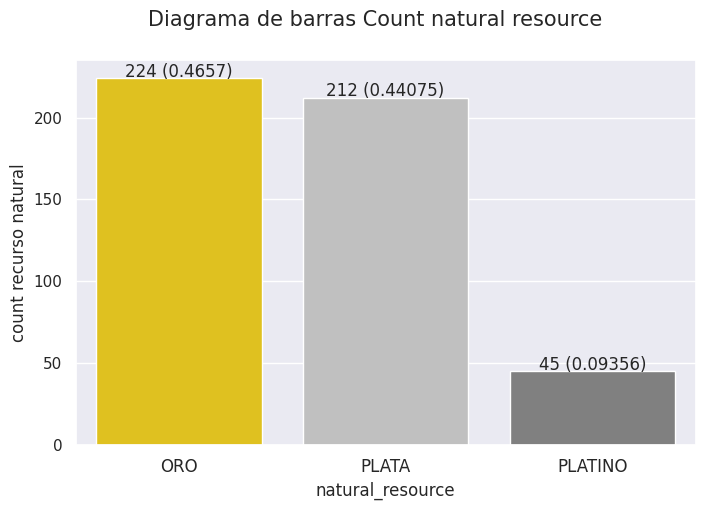

In [264]:
paleta = {
    'ORO': 'gold',
    'PLATA': 'silver',
    'PLATINO': 'gray'
}

plot_bar(data_transaccion, paleta=paleta, ejeX='natural_resource',ejey='count recurso natural',title='Count natural resource', p=True)

# **Encoders and Standardization**
---

**Data Trainer**

In [265]:
category_columns = X_train.select_dtypes(include=['object']).columns.to_list()
numeric_columns = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

In [266]:
preprocessor = ColumnTransformer(
    [
        ('standard', StandardScaler(), numeric_columns),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), category_columns)
    ],  remainder='passthrough'
)

In [267]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

**Data Validation**

In [268]:
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(category_columns)
encoded_cat

array(['natural_resource_ORO', 'natural_resource_PLATA',
       'natural_resource_PLATINO', 'region_Amazonia', 'region_Andina',
       'region_Caribe', 'region_Orinoquia', 'region_Pacifico'],
      dtype=object)

In [269]:
X_validation = preprocessor.transform(X_validation)

In [270]:
pd.DataFrame(X_validation)

,0,1,2,3,4,5,6,7,8,9,10
0,2.20877,3.77832,5.75011,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
1,2.20877,0.59939,0.04227,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
2,2.20877,0.05830,-0.07115,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
3,2.20877,-0.55043,-0.36830,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
4,2.20877,-0.21225,-0.30987,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
...,...,...,...,...,...,...,...,...,...,...,...
179,2.20877,0.39648,-0.31599,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000
180,2.20877,-0.55043,-0.37056,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000
181,2.20877,-0.55043,-0.37082,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000
182,2.20877,-0.55043,-0.30978,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000


# **Model**
---

For this phase, classic models such as Logistic Regression (LR), Gaussian Naive Bayes (GB), K-Nearest Neighbors (KNN), Support Vector Regressor (SVR), and Decision Tree (DT) were used.

In [271]:
index = ['Data Train', 'Data Test', 'Data Validation']

results_no_dt = pd.DataFrame(index=index)

A list was generated with the instances of the first four models mentioned, configured with the default parameters, which are suitable for problems where the relationship between predictors is typically linear.


In [272]:
list_models = [
    ('LR',LinearRegression()),
    ('RG',Ridge(random_state=random_seed)),
    ('GB',GaussianProcessRegressor()),
    ('KNN',KNeighborsRegressor()),
    ('SVR', SVR()),
]

The other list consists of decision trees with low depth (stumps)

In [273]:
list_models_dt = [
    ('DT1',DecisionTreeRegressor(criterion='squared_error',max_depth=2, random_state=random_seed)),
    ('DT2',DecisionTreeRegressor(criterion='squared_error',max_depth=1, random_state=random_seed)),
    ('DT3',DecisionTreeRegressor(criterion='squared_error',max_depth=3, random_state=random_seed)),
]

In [274]:
def generate_score(list_models:list):
  scores = []
  models_m = []
  for model in list_models:
    m = model[1]
    m.fit(X_train_preprocessed, y_train)
    models_m.append((model[0], m))
    y_predict = m.predict(X_test_preprocessed)
    score = mean_absolute_error(y_test, y_predict)
    scores.append(score)
  return scores, models_m

In [275]:
scores, models_m = generate_score(list_models)

A regression metric is used to calculate the importance weight of the model, based on its performance with the 'MAE'

In [276]:
scores

[1380177011.8991213,
 1375595424.6617374,
 6526349170.494537,
 484087389.9216496,
 1634011028.591033]

Since the scores tend to have the dimensions of the variable according to the nature of the variable, the total score is summed up and the performance of the metric is divided by this total, in order to represent the weight as a percentage.

In [277]:
scores_no_dt = [round(i/sum(scores), 2) for i in scores ]
scores_no_dt

[0.12, 0.12, 0.57, 0.04, 0.14]

In [278]:
scores_dt, models_m_dt = generate_score(list_models_dt)

In [279]:
scores_dt = [round(i/sum(scores_dt), 2) for i in scores_dt ]
scores_dt

[0.35, 0.41, 0.24]

# **Averaging Continuous Values**
---
There is no hard or soft voting in regression, because the ensemble is based on averaging continuous values, not on counting votes or averaging class probabilities.

In [280]:
ensembleVotingWekLearns = VotingRegressor(estimators=list_models, weights=scores_no_dt)
ensembleVotingWekLearns.fit(X_train_preprocessed, y_train)
y_predTrWekLearns = ensembleVotingWekLearns.predict(X_train_preprocessed)
y_predTeWekLearns = ensembleVotingWekLearns.predict(X_test_preprocessed)
y_predVaWekLearns = ensembleVotingWekLearns.predict(X_validation)

mae_score_train = mean_absolute_error(y_train, y_predTrWekLearns)
mae_score_test  = mean_absolute_error(y_test, y_predTeWekLearns)
mae_score_vali  = mean_absolute_error(y_validation, y_predVaWekLearns)
mae_score_train, mae_score_test, mae_score_vali

(577177693.5509204, 3991322581.562655, 12904732727.084936)

In [281]:
results_no_dt['score_vouting_no_dt'] = [mae_score_train, mae_score_test, mae_score_vali]

In [282]:
results_no_dt

,score_vouting_no_dt
Data Train,"577,177,693.55092"
Data Test,"3,991,322,581.56265"
Data Validation,"12,904,732,727.08494"


In [283]:
for model in models_m:
  m = model[1]
  y_predTr = m.predict(X_train_preprocessed)
  y_predTe = m.predict(X_test_preprocessed)
  y_predVa = m.predict(X_validation)

  mae_score_train = mean_absolute_error(y_train, y_predTr)
  mae_score_test  = mean_absolute_error(y_test, y_predTe)
  mae_score_vali  = mean_absolute_error(y_validation, y_predVa)
  print(model[0], mae_score_train, mae_score_test, mae_score_vali)
  results_no_dt[model[0]] = [mae_score_train, mae_score_test, mae_score_vali]


LR 1504843472.6782625 1380177011.8991213 3328651829.670665
RG 1498930637.7390225 1375595424.6617374 3310072819.067052
GB 5704484.164242719 6526349170.494537 21419973219.417023
KNN 565706603.8822917 484087389.9216496 1985937312.9130435
SVR 1867314275.1442935 1634011028.591033 3123119500.8166738


In [284]:
results_no_dt

,score_vouting_no_dt,LR,RG,GB,KNN,SVR
Data Train,"577,177,693.55092","1,504,843,472.67826","1,498,930,637.73902","5,704,484.16424","565,706,603.88229","1,867,314,275.14429"
Data Test,"3,991,322,581.56265","1,380,177,011.89912","1,375,595,424.66174","6,526,349,170.49454","484,087,389.92165","1,634,011,028.59103"
Data Validation,"12,904,732,727.08494","3,328,651,829.67066","3,310,072,819.06705","21,419,973,219.41702","1,985,937,312.91304","3,123,119,500.81667"


-

It is evident that the assembled model has a lower loss on the training data compared to the other models. However, on the validation and test data, the assembled model performs poorly, suggesting that the individual models work better than when combined.

In [285]:
ensembleVotingDt = VotingRegressor(estimators=list_models_dt, weights=scores_dt)
ensembleVotingDt.fit(X_train_preprocessed, y_train)
y_predTrDt = ensembleVotingDt.predict(X_train_preprocessed)
y_predTeDt = ensembleVotingDt.predict(X_test_preprocessed)
y_predVaDt = ensembleVotingDt.predict(X_validation)

mae_score_train = mean_absolute_error(y_train, y_predTrDt)
mae_score_test  = mean_absolute_error(y_test, y_predTeDt)
mae_score_vali  = mean_absolute_error(y_validation, y_predVaDt)
mae_score_train, mae_score_test, mae_score_vali

(1467250004.6351364, 1352187678.1110551, 3093618995.239397)

In [286]:
results_no_dt['score_vouting_dt'] = [mae_score_train, mae_score_test, mae_score_vali]

In [287]:
for model in models_m_dt:
  m = model[1]
  y_predTr = m.predict(X_train_preprocessed)
  y_predTe = m.predict(X_test_preprocessed)
  y_predVa = m.predict(X_validation)

  mae_score_train = mean_absolute_error(y_train, y_predTr)
  mae_score_test  = mean_absolute_error(y_test, y_predTe)
  mae_score_vali  = mean_absolute_error(y_validation, y_predVa)
  print(model[0], mae_score_train, mae_score_test, mae_score_vali)
  results_no_dt[model[0]] = [mae_score_train, mae_score_test, mae_score_vali]

DT1 1487173198.1817753 1457863112.8881018 3250691453.341468
DT2 1932367111.0651042 1736745316.7525773 3390948057.8288045
DT3 1004685750.1407913 1026132543.4072213 2630714880.670247


In [288]:
results_no_dt

,score_vouting_no_dt,LR,RG,GB,KNN,SVR,score_vouting_dt,DT1,DT2,DT3
Data Train,"577,177,693.55092","1,504,843,472.67826","1,498,930,637.73902","5,704,484.16424","565,706,603.88229","1,867,314,275.14429","1,467,250,004.63514","1,487,173,198.18178","1,932,367,111.06510","1,004,685,750.14079"
Data Test,"3,991,322,581.56265","1,380,177,011.89912","1,375,595,424.66174","6,526,349,170.49454","484,087,389.92165","1,634,011,028.59103","1,352,187,678.11106","1,457,863,112.88810","1,736,745,316.75258","1,026,132,543.40722"
Data Validation,"12,904,732,727.08494","3,328,651,829.67066","3,310,072,819.06705","21,419,973,219.41702","1,985,937,312.91304","3,123,119,500.81667","3,093,618,995.23940","3,250,691,453.34147","3,390,948,057.82880","2,630,714,880.67025"


Stump decision trees perform poorly compared to their non-tree counterparts as the average error is higher. However, when they are assembled, they manage to reduce the error in validation and test data, compared to their unassembled counterpart.

# **Info**
---
**@By**: **Steven Bernal**

**@Nickname**: **Kaiziferr**

**@Git**: https://github.com/Kaiziferr